In [1]:
# Arvind Prasadan
# 2019 January
# DMF Package 
# Real Data Simulations

# DMF Package
push!(LOAD_PATH, "../src/")
using DMF

# Basic Linear Algebra Functionality
using LinearAlgebra
using Statistics
using StatsBase

# Plotting and Output
using Plots
using Measures
using LaTeXStrings

# File IO
using FileIO
using JLD2
using WAV

# Set plotting interface
pyplot()

Plots.PyPlotBackend()

In [17]:
# Arvind Prasadan
# 2019 January
# DMF Package
# SOBI Function (R) Wrapper

using RCall

"""
	 SOBI_Wrapper(X, lags)

A wrapper function for the Second Order Blind Identification (SOBI) Source Separation algorithm. This is a wrapper that calls the function from R, and depends on the presence of an R install as well as the jointDiag package being installed.

# Arguments
- `X`: Data matrix, p dimensions/sensors x n samples
- `lags`: List of (Integral) lags for the algorithm to operate at

# Outputs
- `Q_hat`: Eigenvector Estimates
- `S_hat: The recovered latent time series
"""
function SOBI_Wrapper(X, lags)
    
    n = size(X, 2)
    p = size(X, 1)
    
    # Sanity check lags
    lags = abs.(Int.(round.(lags)))
    if 1 < length(lags)
        lags = [min(x, n - 1) for x in lags]
        lags = sort(unique(lags))
    end
    
    # Whiten X
    mu = mean(X; dims = 2)
    X = X .- mu
    cov_X = X * X'
    cov_X = (cov_X + cov_X') / 2.0
    cW, cV = eigen(cov_X)
    cov_invsqrt = cV * Diagonal(sqrt.(abs.(pinv(cW)))) * cV'
    cov_sqrt = cV * Diagonal(sqrt.(abs.(cW))) * cV'
    Xw = cov_invsqrt * X

    # Store matrices at different lags
    A = zeros(p, p, length(lags))
    for ll = 1:1:length(lags)
	    A[:, :, ll] = Xw[:, (lags[ll] + 1):end] * pinv(Xw[:, 1:(end - lags[ll])]) + Diagonal(ones(p)) # Regularizer
    end

    # Put Variables in R
    R"library(jointDiag)"
    R"A = $(A)"

    # Run SOBI: Joint Diagonalization
    Q_hat = reval("ajd(A, method = \"jedi\")\$A")
    Q_hat = convert(Array{Float64, 2}, Q_hat)  
    Q_hat = cov_sqrt * Q_hat
    
    S_hat = (pinv(Q_hat) * (X .+ mu))'

    return (Q_hat, S_hat)
end

    


SOBI_Wrapper

# Audio Mixing

In [2]:
# Load Audio
s1, fs = wavread("data/source1.wav")
s2, fs = wavread("data/source5.wav")

s1 = normalize(s1[:])
s2 = normalize(s2[:])
C = Matrix([s1'; s2']')

@show s1' * s2

s1' * s2 = -0.003186242797727691


-0.003186242797727691

In [3]:
# For plotting: scaling functions 
scale_min(x) = x .- minimum(x[:])
scale_max(x) = x ./ maximum(x[:])
scale_11(x) = (2.0 * scale_max(scale_min(x))) .- 1.0

scale_11 (generic function with 1 method)

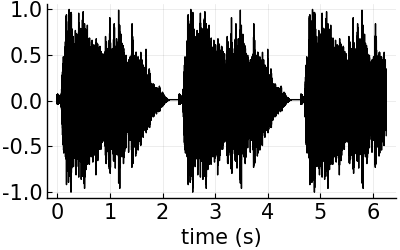

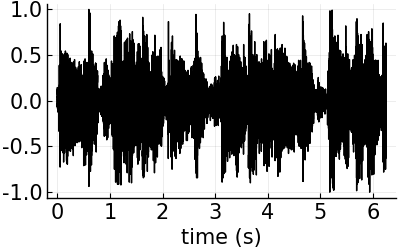

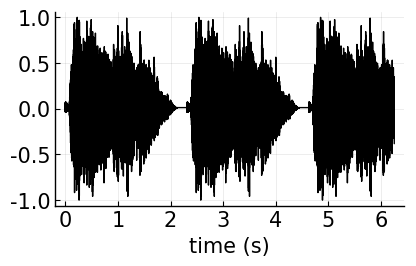

In [30]:
p1 = plot(reuse = false, size = (500, 300))
p1 = plot!((1:1:length(s1)) ./ Int(fs), scale_11(s1), xlabel = "time (s)", title = "Audio Signal 1", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :black)
font = Plots.font("Helvetica", 15)
p1 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))

p2 = plot(reuse = false, size = (500, 300))
p2 = plot!((1:1:length(s2)) ./ Int(fs), scale_11(s2), xlabel = "time (s)", title = "Audio Signal 2", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :black)
font = Plots.font("Helvetica", 15)
p2 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))


display(plot(p1, title = ""))
display(plot(p2, title = ""))

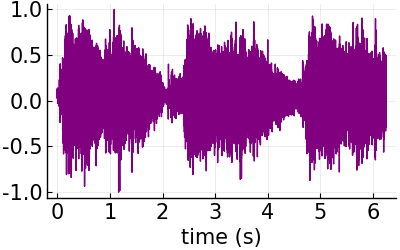

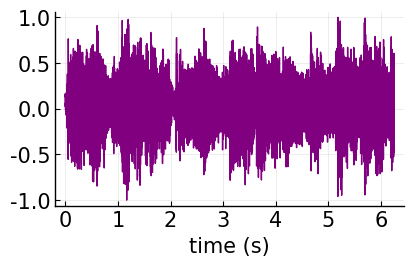

In [29]:
Q = [1 2; 2 1]
Q = mapslices(normalize, Q; dims = 1)

X = Q * C'

p1 = plot(reuse = false, size = (500, 300))
p1 = plot!((1:1:length(s1)) / Int(fs), scale_11(X[1, :]), xlabel = "time (s)", title = "Mixed Signal 1", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :purple)
font = Plots.font("Helvetica", 15)
p1 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))

p2 = plot(reuse = false, size = (500, 300))
p2 = plot!((1:1:length(s2)) / Int(fs), scale_11(X[2, :]), xlabel = "time (s)", title = "Mixed Signal 2", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :purple)
font = Plots.font("Helvetica", 15)
p2 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))


display(plot(p1, title = ""))
display(plot(p2, title = ""))


In [8]:
# Perform DMD

_, Q_hat, C_hat, _ = dmf(X; C_nsv = 2)
@show eigenvector_error(Q, Q_hat[:, 1:2])
@show eigenvector_error(C, C_hat)

eigenvector_error(Q, Q_hat[:, 1:2]) = 1.0788301498365627e-5
eigenvector_error(C, C_hat) = 2.9776174824691637e-5


2.9776174824691637e-5

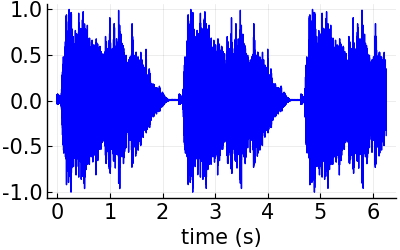

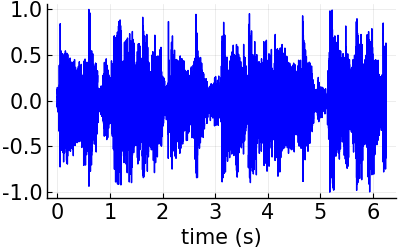

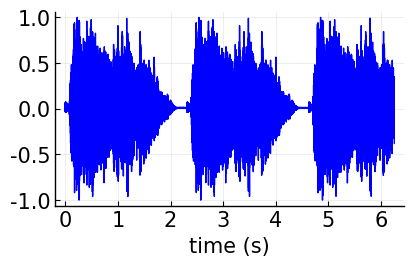

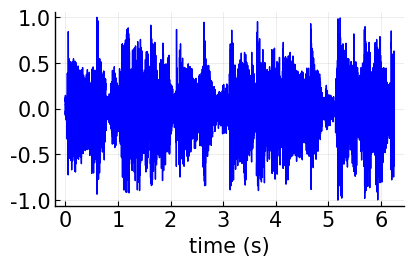

In [28]:
sort_idx = sortperm(abs.(C_hat[:, 1:2]' * C)[:, 1], rev = true)

p1 = plot(reuse = false, size = (500, 300))
p1 = plot!((1:1:length(s1)) / Int(fs), scale_11(C_hat[:, sort_idx[1]]), xlabel = "time (s)", title = "Unmixed Signal 1", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :blue)
font = Plots.font("Helvetica", 15)
p1 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))


p2 = plot(reuse = false, size = (500, 300))
p2 = plot!((1:1:length(s2)) / Int(fs), scale_11(C_hat[:, sort_idx[2]]), xlabel = "time (s)", title = "Unmixed Signal 2", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :blue)
font = Plots.font("Helvetica", 15)
p2 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))


display(plot(p1, title = ""))
display(plot(p2, title = ""))

In [10]:
# SVD

U, s, V = svd(X, full = false)

@show eigenvector_error(Q, U[:, 1:2])
@show eigenvector_error(C, V[:, 1:2])

eigenvector_error(Q, U[:, 1:2]) = 1.4701778718652956
eigenvector_error(C, V[:, 1:2]) = 1.1715764645898348


1.1715764645898348

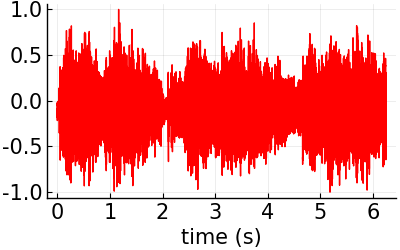

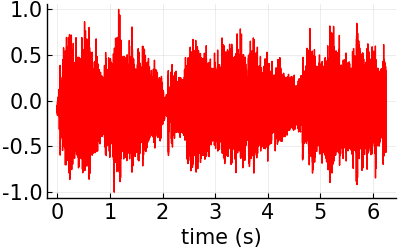

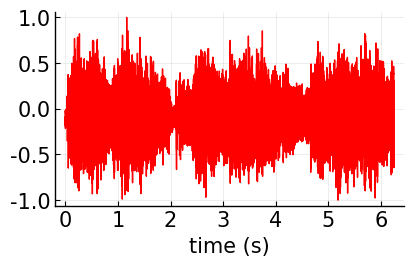

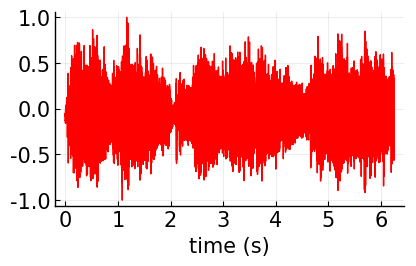

In [27]:
sort_idx = sortperm(abs.(V[:, 1:2]' * C)[:, 1], rev = true)

p1 = plot(reuse = false, size = (500, 300))
p1 = plot!((1:1:length(s1)) / Int(fs), scale_11(V[:, sort_idx[1]]), xlabel = "time (s)", title = "SVD Signal 1", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :red)
font = Plots.font("Helvetica", 15)
p1 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))


p2 = plot(reuse = false, size = (500, 300))
p2 = plot!((1:1:length(s2)) / Int(fs), scale_11(V[:, sort_idx[2]]), xlabel = "time (s)", title = "SVD Signal 2", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :red)
font = Plots.font("Helvetica", 15)
p2 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))


display(plot(p1, title = ""))
display(plot(p2, title = ""))

In [12]:
# ICA
tmp = load("data/audio_ICA.jld2")
C_hat_ICA = Matrix(tmp["Xica"]')

@show eigenvector_error(C, C_hat_ICA)

eigenvector_error(C, C_hat_ICA) = 0.0015358960031433


0.0015358960031433

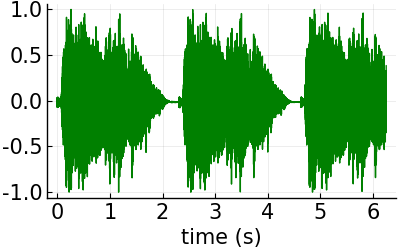

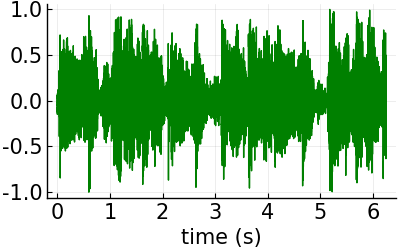

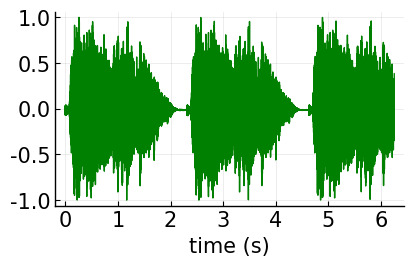

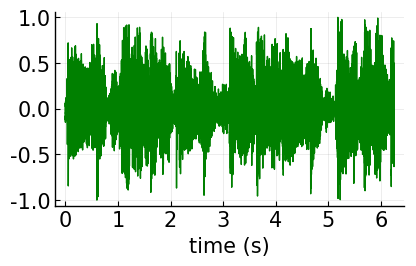

In [26]:
sort_idx = sortperm(abs.(C_hat_ICA[:, 1:2]' * C)[:, 1], rev = true)

p1 = plot(reuse = false, size = (500, 300))
p1 = plot!((1:1:length(s1)) / Int(fs), scale_11(C_hat_ICA[:, sort_idx[1]]), xlabel = "time (s)", title = "ICA Signal 1", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :green)
font = Plots.font("Helvetica", 15)
p1 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))


p2 = plot(reuse = false, size = (500, 300))
p2 = plot!((1:1:length(s2)) / Int(fs), scale_11(C_hat_ICA[:, sort_idx[2]]), xlabel = "time (s)", title = "ICA Signal 2", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :green)
font = Plots.font("Helvetica", 15)
p2 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))


display(plot(p1, title = ""))
display(plot(p2, title = ""))

In [23]:
# SOBI

C_SOBI = Matrix(SOBI_Wrapper(X, [1])[2])
@show eigenvector_error(C, C_SOBI)


eigenvector_error(C, C_SOBI) = 0.11146286680967865


0.11146286680967865

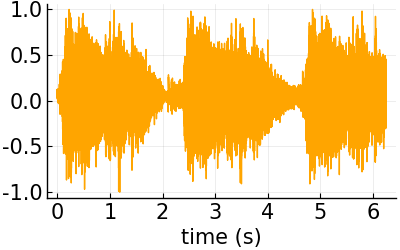

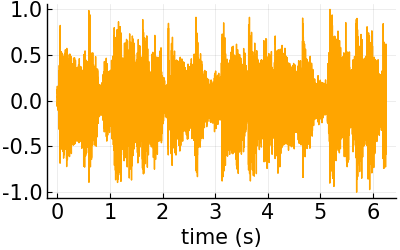

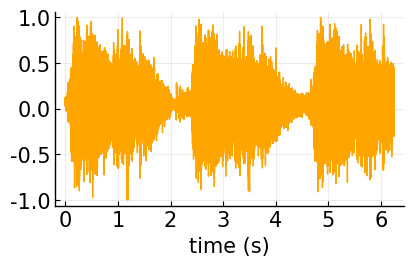

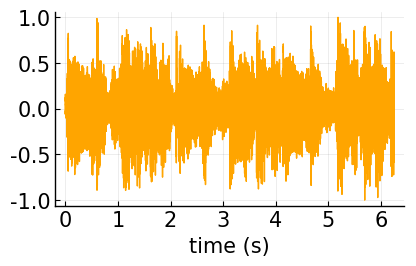

In [25]:

sort_idx = sortperm(abs.(C_SOBI[:, 1:2]' * C)[:, 1], rev = true)

p1 = plot(reuse = false, size = (500, 300))
p1 = plot!((1:1:length(s1)) / Int(fs), scale_11(C_SOBI[:, sort_idx[1]]), xlabel = "time (s)", title = "SOBI Signal 1", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :orange)
font = Plots.font("Helvetica", 15)
p1 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))


p2 = plot(reuse = false, size = (500, 300))
p2 = plot!((1:1:length(s2)) / Int(fs), scale_11(C_SOBI[:, sort_idx[2]]), xlabel = "time (s)", title = "SOBI Signal 2", legend = false, tickfont = Plots.font("Helvetica", 11), guidefont = Plots.font("Helvetica", 13), titlefont = Plots.font("Helvetica", 13), color = :orange)
font = Plots.font("Helvetica", 15)
p2 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))


display(plot(p1, title = ""))
display(plot(p2, title = ""))


# Changepoint

In [31]:
# Make Data

n = 1000
n_frac = 0.5
seq_len = Int(n * n_frac)

k = 4
p = 4

S = hcat([gen_arma_sequence(seq_len, [0.2, 0.7], []); zeros(seq_len)],
        [zeros(seq_len); gen_arma_sequence(seq_len, [0.3, 0.5], [])],
        [gen_cos_sequence(seq_len, 2.0)[1]; zeros(seq_len)],
        [zeros(seq_len); gen_cos_sequence(seq_len, 0.5)[1]]
    )
S = mapslices(normalize, S; dims = 1)

Q = [1 0 0 2; 2 1 0 0; 0 2 1 0; 0 0 2 1]
Q = mapslices(normalize, Q; dims = 1)

X = Q * S'

4×1000 Array{Float64,2}:
 0.0234325   0.038046    0.0259423  …  -0.0537719  -0.0388124  -0.0143502 
 0.046865    0.076092    0.0518846     -0.025797    0.010591    0.0104723 
 0.028271   -0.0117649  -0.0184791     -0.051594    0.0211821   0.0209446 
 0.0565419  -0.0235297  -0.0369583     -0.0268859  -0.0194062  -0.00717511

In [32]:
# Perform DMD

_, Q_hat, C_hat, _ = dmf(X; C_nsv = k)
@show eigenvector_error(Q, Q_hat)
@show eigenvector_error(S, Matrix(C_hat))

eigenvector_error(Q, Q_hat) = 0.0012487756585721765
eigenvector_error(S, Matrix(C_hat)) = 0.001482294702215281


0.001482294702215281

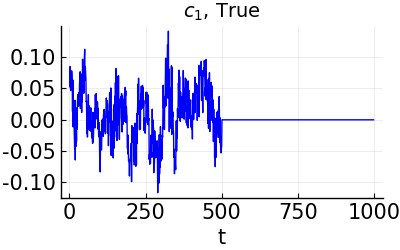

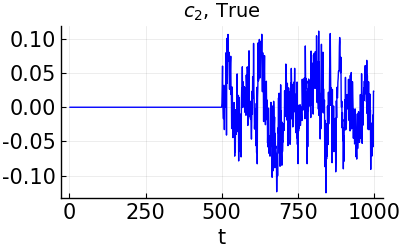

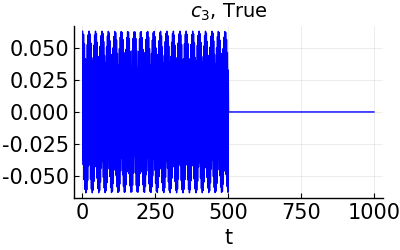

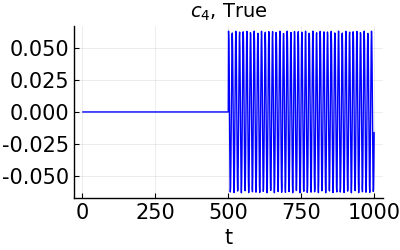

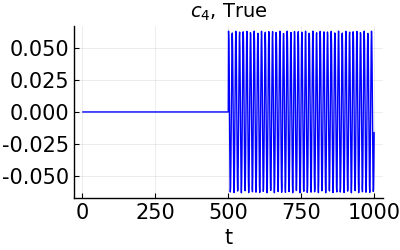

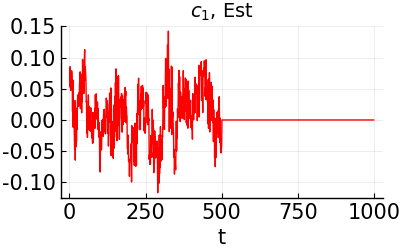

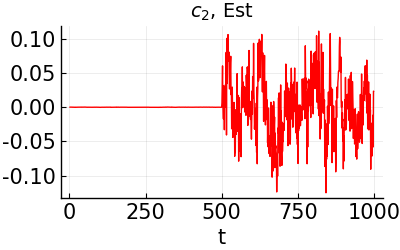

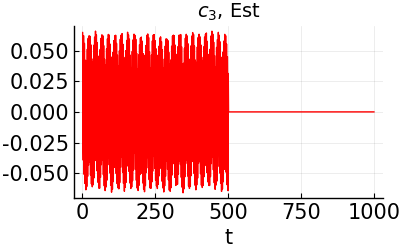

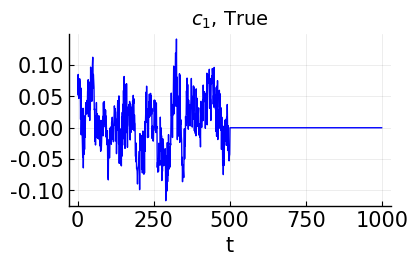

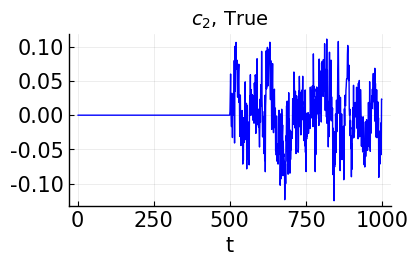

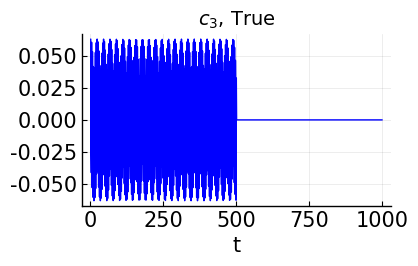

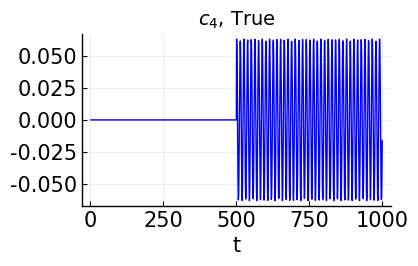

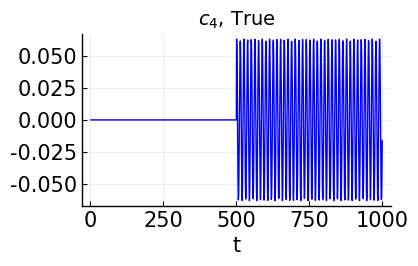

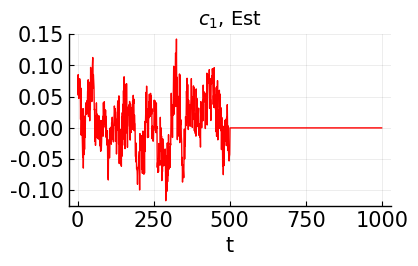

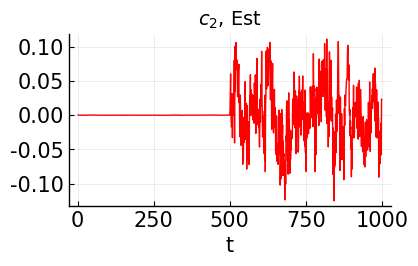

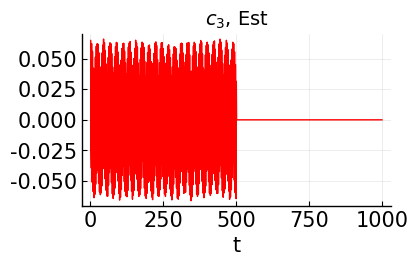

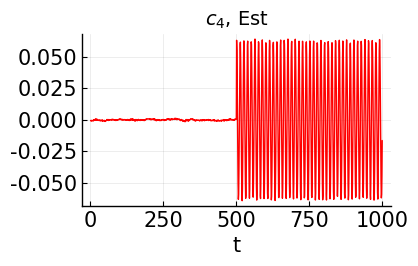

In [33]:
S_IP = abs.(S' * mapslices(normalize, C_hat; dims = 1))

plot_arr = []
c_str = [L"c_1", L"c_2", L"c_3", L"c_4"]
for p_idx = 1:1:k
    p1 = plot(reuse = false)
    p1 = plot!(real.(S[:, p_idx]), title = c_str[p_idx] * ", True", xlabel = "t", legend = false, color = :blue)
    font = Plots.font("Helvetica", 15)
    p1 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))

    push!(plot_arr, p1)
end
for p_idx = 1:1:k
    p1 = plot(reuse = false)
    
    plot_tmp = real.(C_hat[:, findmax(S_IP[p_idx, :])[2]])
    plot_tmp = sign(plot_tmp' * S[:, p_idx]) * plot_tmp
    
    p1 = plot!(plot_tmp, title = c_str[p_idx] * ", Est", xlabel = "t", legend = false, color = :red)
    font = Plots.font("Helvetica", 15)
    p1 = plot!(legendfont = font, guidefont = font, xtickfont = font, ytickfont = font, size = (400, 250))

    
    push!(plot_arr, p1)
end
trace_size = (400, 250)
display(plot(plot_arr[1], size = trace_size))
display(plot(plot_arr[2], size = trace_size))
display(plot(plot_arr[3], size = trace_size))
display(plot(plot_arr[4], size = trace_size))
display(plot(plot_arr[4], size = trace_size))
display(plot(plot_arr[5], size = trace_size))
display(plot(plot_arr[6], size = trace_size))
display(plot(plot_arr[7], size = trace_size))
display(plot(plot_arr[8], size = trace_size))